Basic_TextPreprocessing_BoW_TFIDF_Logistic_NB_GridSearch

# Real or Not? NLP with Disaster Tweets

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this notebook we are going to try to develop a solution for the public competition "Real or Not? NLP with Disaster Tweets" hosted by Kaggle. In this competition, we’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We’ll have access to a dataset of 10,000 tweets that were hand classified. 

Each sample in the train and test set has the following information:
- An identification number for each tweet
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

Moreover, in the train set is also available the actual value of the target variable.

Finally, submissions are evaluated using 'F1' between the predicted and expected answers.

## Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# Training data
df_train = pd.read_csv('input/train.csv')
print('Training data has {} observations and {} columns.'.format(df_train.shape[0], df_train.shape[1]))
df_train.head()

Training data has 7613 observations and 5 columns.


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [4]:
# Testing data
df_test = pd.read_csv('input/test.csv')
print('Testing data has {} observations and {} columns.'.format(df_test.shape[0], df_test.shape[1]))
df_test.head()

Testing data has 3263 observations and 4 columns.


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

Note here that we can already see some missing values in the 'keyword' and 'location' columns. Let's do a quick EDA to get a basic idea of the data we are dealing with. 

## Quick EDA

#### Unique values per variable

In [6]:
# Train
print('-- Training data --')
for i in df_train.columns:
    print('{}, {} valores únicos'.format(i, len(df_train[i].unique())))

-- Training data --
id, 7613 valores únicos
keyword, 222 valores únicos
location, 3342 valores únicos
text, 7503 valores únicos
target, 2 valores únicos


In [7]:
# Test
print('-- Testing data --')
for i in df_test.columns:
    print('{}, {} valores únicos'.format(i, len(df_test[i].unique())))

-- Testing data --
id, 3263 valores únicos
keyword, 222 valores únicos
location, 1603 valores únicos
text, 3243 valores únicos


**Notes**:
- There is a unique 'id' value for each observation in both train and test sets
- The 'keyword' column has the same number of unique values in both train and test sets. After a quick check, we can verify that the same set of values is being used in both datasets.
- As expected, the 'location' column has a huge number of unique values.
- Surprisingly, there are a few tweets in both train and test which have the same text. We will have to check that later.

Taking into account the large amount of unique values in both 'keyword' and 'location' columns, let's check only the 20 most common values in each column.

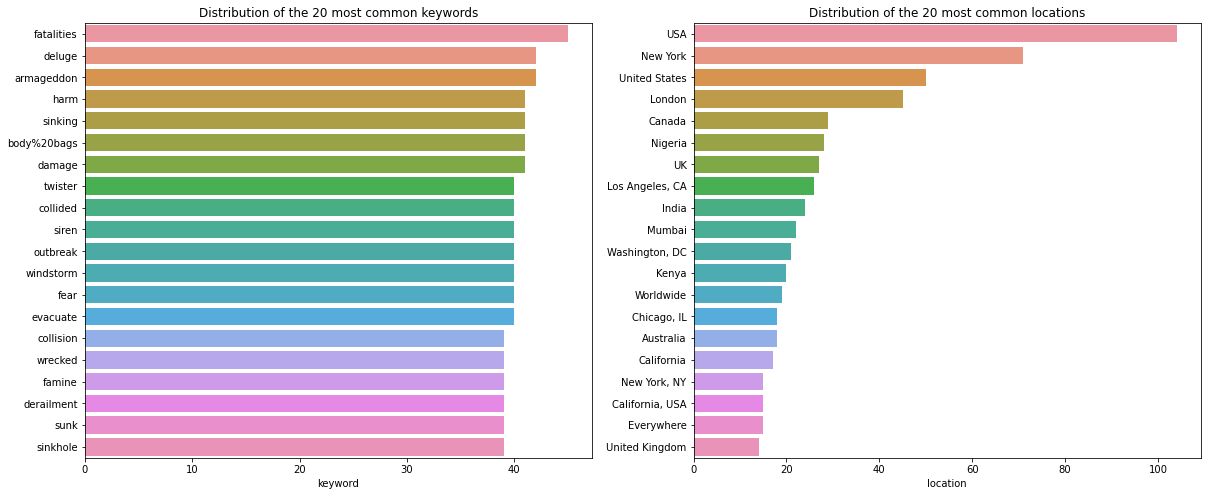

In [8]:
# Distribution of the 20 most frequent values in KEYWORD and LOCATION columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 8])

plt.subplot(1, 2, 1)
ax1 = sns.barplot(x=df_train['keyword'].value_counts()[:20], 
                 y=df_train['keyword'].value_counts()[:20].index,
                 orient='h')

plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=df_train['location'].value_counts()[:20], 
                 y=df_train['location'].value_counts()[:20].index,
                 orient='h')

ax1.set_title('Distribution of the 20 most common keywords')
ax2.set_title('Distribution of the 20 most common locations')
plt.show()

Looking at the plot of the most common locations, the need of a deep cleaning of the 'location' values becomes clear. However, in this notebook we are going to focus only on the 'text' column to build the models and make our predictions. 

#### Missing values

In [9]:
print('Percentage of missing values per column in training set:')
round(df_train.isnull().sum()/len(df_train), 3)

Percentage of missing values per column in training set:


id          0.000
keyword     0.008
location    0.333
text        0.000
target      0.000
dtype: float64

In [10]:
print('Percentage of missing values per column in test set:')
round(df_test.isnull().sum()/len(df_test), 3)

Percentage of missing values per column in test set:


id          0.000
keyword     0.008
location    0.339
text        0.000
dtype: float64

Since missing value ratios between training and test set are too close, they are most probably taken from the same sample. However, as we have said before, we are not going to work with these variables in this notebook.

#### 'Target' variable

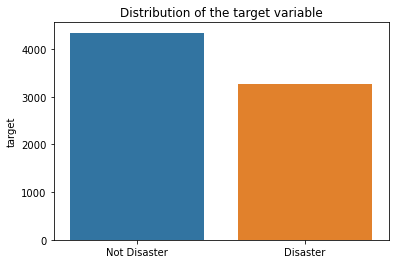

In [11]:
# Distribution
fig= sns.barplot(['Not Disaster', 'Disaster'], df_train.target.value_counts())
fig.set_title('Distribution of the target variable')

plt.show()

Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). Classes are almost equally separated so they don't require neither applying techniques for dealing with imbalanced classes nor any stratification by target in cross-validation.

#### 'Text' variable

From now on, let's focus on the 'text' column, inspecting it to understand what is needed to get the most of this feature and to remove the noise which could be present in this variable.

In [12]:
# A quick glance over the text data
pd.set_option('display.max_colwidth', 120)

df_train['text'][:10]

0                                                      Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                     Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...
3                                                          13,000 people receive #wildfires evacuation orders in California 
4                                   Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
5             #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6                            #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
7                                                                I'm on top of the hill and I can see a fire in the woods...


As we can see, some kind of cleanning techniques are going to be needed to normalize the text in tweets, this way preventing the performance of our models from being affected by useless information.

## Text Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format. We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:
- Make text all lower case or uppercase so that the algorithm does not treat the same words in different cases as different
- Removing noise i.e everything that isn’t in a standard number or letter (punctuation, numerical values, common non-sensical text (/n), etc.).
- Tokenization
- Stopwords removal

Further data cleaning steps to consider:
- Stemming
- Lemmatization
- Parts of speech tagging
- Create bi-grams or tri-grams 
- And more...

For a start, we are going to do a basic cleanning of the 'text' column, making all text lowercase and removing links, possible HTML tags, Twitter mentions and punctuation characters.

In [13]:
# Applying tweet cleaning techniques

def clean_tweet(tweet):
    '''Make tweet lowercase, remove links, remove HTML tags, remove mentions, remove punctuation, 
    remove newline characters and remove extra spaces.'''
    tweet = tweet.lower()
    tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    tweet = re.sub('<.*?>', '', tweet)
    tweet = re.sub('(?<=@)\w+', '', tweet)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\s+', ' ', tweet).strip() # Remove leading, trailing, and extra spaces

    return tweet

# Applying the cleaning function to both test and training datasets
df_train['text'] = df_train['text'].apply(lambda x: clean_tweet(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_tweet(x))

In [14]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)

df_train['text'] = df_train['text'].apply(lambda x: remove_emoji(x))
df_test['text'] = df_test['text'].apply(lambda x: remove_emoji(x))

In [15]:
# Let's take a look at the updated text
df_train['text'].head(10)

0                                                       our deeds are the reason of this earthquake may allah forgive us all
1                                                                                      forest fire near la ronge sask canada
2    all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place order...
3                                                             13000 people receive wildfires evacuation orders in california
4                                      just got sent this photo from ruby alaska as smoke from wildfires pours into a school
5                      rockyfire update california hwy 20 closed in both directions due to lake county fire cafire wildfires
6                               flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
7                                                                    im on top of the hill and i can see a fire in the woods


## Transforming preprocessed text into a vector (or array)

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. In this notebook we are going to consider two approaches to do this: Bag of Words and TFIDF Features.

### Bag of Words

The bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:
- A vocabulary of known words
- A measure of the presence of known words

We can do this using scikit-learn's CountVectorizer, where every row will represent a different tweet and every column will represent a different word. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization and stop word removal. We are going to customize our vectorizer using these arguments and values:
- Ignore words which appear in only one tweet
- Ignore words which appear in more than half of the tweets
- Only consider unigrams
- Remove English stopwords

In [16]:
# Instantiating CountVectorizer
count_vectorizer = CountVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 1), stop_words='english')
train_vectors = count_vectorizer.fit_transform(df_train['text'])
test_vectors = count_vectorizer.transform(df_test["text"])

### TFIDF Features

A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (i.e. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents, so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency (TFIDF).

When instantiating our vectorizer, we are going to use the same options as in the previous approach. 

In [17]:
# Instantiating TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 1), stop_words='english')
train_tfidf = tfidf.fit_transform(df_train['text'])
test_tfidf = tfidf.transform(df_test["text"])

## Building a Text Classification model

Now the data is ready to be fed into a classification model. Let's create a basic clasification model using commonly used classification algorithms and see how our model performs.

### Logistic Regression Classifier

In [18]:
# Fitting a Logistic Regression on counts (Bag of Words approach)
clf = LogisticRegression(solver='liblinear')
scores = model_selection.cross_val_score(clf, train_vectors, df_train["target"], cv=10, scoring="f1")
scores.mean()

0.5416174511517224

In [19]:
clf.fit(train_vectors, df_train["target"])

LogisticRegression(solver='liblinear')

In [20]:
# Fitting Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(solver='liblinear')
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, df_train["target"], cv=10, scoring="f1")
scores.mean()

0.5417446163733686

In [21]:
clf_tfidf.fit(train_vectors, df_train["target"])

LogisticRegression(solver='liblinear')

### Naives Bayes Classifier

In [22]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, df_train["target"], cv=10, scoring="f1")
scores.mean()

0.6246722766712904

In [23]:
clf_NB.fit(train_vectors, df_train["target"])

MultinomialNB()

In [24]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, df_train["target"], cv=10, scoring="f1")
scores.mean()

0.6135850762825769

In [25]:
clf_NB_TFIDF.fit(train_tfidf, df_train["target"])

MultinomialNB()

### XGBoost

In [26]:
%%time

clf_xgb = xgb.XGBClassifier(max_depth=8, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.8, learning_rate=0.1)

scores = model_selection.cross_val_score(clf_xgb, train_vectors, df_train["target"], cv=10, scoring="f1")
scores.mean()

Wall time: 15.6 s


0.45753401191227666

In [27]:
clf_xgb.fit(train_vectors, df_train["target"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=8, n_estimators=300, colsample_bytree=0.8, 
                        subsample=0.8, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, df_train["target"], cv=10, scoring="f1")
scores.mean()

0.4489101883594319

In [29]:
clf_xgb_TFIDF.fit(train_tfidf, df_train["target"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Hyperparameters Tunning

GridSearchCV provides a way to test several values for hyper-parameters. Using GridSearchCV, we can cross-validated many different hyper-parameters combinations to find out the one set of hyper-parameters which yield the best score.

In [30]:
grid_param = {
    'alpha': [0.01, 0.1, 1, 10],
    'fit_prior': [True, False]
    }

In [31]:
model_grid = GridSearchCV(estimator=clf_NB,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=10,
                     n_jobs=-1)

In [32]:
%%time

model_grid.fit(train_vectors, df_train["target"])

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'fit_prior': [True, False]},
             scoring='f1')

In [33]:
print(model_grid.best_params_)

{'alpha': 10, 'fit_prior': False}


In [34]:
print(model_grid.best_score_)

0.628185820210007


In [35]:
model_grid_tfidf = GridSearchCV(estimator=clf_NB_TFIDF,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=10,
                     n_jobs=-1)

In [36]:
model_grid_tfidf.fit(train_tfidf, df_train["target"])

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'fit_prior': [True, False]},
             scoring='f1')

In [37]:
print(model_grid_tfidf.best_params_)

{'alpha': 10, 'fit_prior': False}


In [38]:
print(model_grid_tfidf.best_score_)

0.6341760762120312


## Submission

In [39]:
submission = pd.read_csv('sample_submission.csv')

In [40]:
submission.target = clf_NB.predict(test_vectors)

In [41]:
submission.to_csv('submission_bow.csv', index=False) #0,79711 score in Kaggle 

In [42]:
submission.target = clf_NB_TFIDF.predict(test_vectors)

In [43]:
submission.to_csv('submission_tfidf.csv', index=False) #0.79405 score in Kaggle